# Commute Weather – 21-Month Deep Dive
기상 데이터 21개월치에 대한 심층 EDA, 계절/지역 패턴 분석, 이상치 탐지, 품질 리포트를 수행합니다.


## 0. 사전 준비
- `.env` 설정을 로드하여 KMA/S3 자격 증명을 불러옵니다.
- 도커 개발 컨테이너에서 `pip install matplotlib seaborn statsmodels` 등을 설치해 주세요.


In [1]:
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.data.weather_processor import WeatherDataProcessor
from src.utils.config import KMAApiConfig, S3Config
from src.eda import build_overall_profile, build_station_profile, run_data_quality_checks
from src.visualization import WeatherVisualizationReport
from src.features.feature_builder import add_engineered_features
from src.utils.logger_config import configure_logger

kma_config = KMAApiConfig.from_env()
s3_config = S3Config.from_env()
processor = WeatherDataProcessor(kma_config=kma_config, s3_config=s3_config)
logger = configure_logger("long_term_analysis")

logger.info("환경 설정 완료")


2025-09-25 17:29:27 | INFO | S3StorageClient | S3 버킷 확인: weather-mlops-team-data
2025-09-25 17:29:27 | INFO | long_term_analysis | 환경 설정 완료


## 1. 데이터 로딩
- CSV 기반 통합 데이터를 읽어옵니다.
- 현재 노트북 위치가 `/app/notebooks`이므로 프로젝트 루트를 자동으로 계산합니다.


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
CSV_PATH = PROJECT_ROOT / "data" / "interim" / "weather_pm10_integrated_full.csv"
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV 파일이 존재하지 않습니다: {CSV_PATH}")

dataset = pd.read_csv(CSV_PATH, parse_dates=["datetime"], low_memory=False)
logger.info("CSV 로드 완료", extra={"rows": len(dataset), "columns": list(dataset.columns)})
dataset.head()


2025-09-25 17:29:30 | INFO | long_term_analysis | CSV 로드 완료


,YYMMDDHHMI,STN,WD,WS,GST,GST_2,GST_3,PA,PS,PT,...,TE_3,TE_4,ST_2,WH,BF,IR,IX,datetime,PM10,PM10_FLAG
0,202401010900,100,9,0.8,-9,-9.0,-9,936.9,1031.7,2,...,-99.0,-99.0,-9,-9.0,-9,3,-9,2024-01-01 09:00:00,15.000000,000000
1,202401010900,102,14,2.3,-9,-9.0,-9,1023.8,1028.4,2,...,-99.0,-99.0,-9,1.0,-9,3,1,2024-01-01 09:00:00,56.500000,000000
2,202401010900,108,5,1.3,-9,-9.0,-9,1018.2,1029.1,2,...,0.1,1.0,-9,-9.0,-9,3,1,2024-01-01 09:00:00,14.666667,000000
3,202401010900,115,7,5.3,7,15.0,345,1002.4,1030.1,2,...,4.6,4.7,5,3.5,3,3,2,2024-01-01 09:00:00,19.333333,000000
4,202401010900,119,0,0.3,-9,-9.0,-9,1024.9,1030.0,2,...,1.3,1.9,-9,-9.0,-9,3,1,2024-01-01 09:00:00,29.833333,000000


In [3]:
if not dataset.empty:
    dataset = dataset.rename(columns={
        "STN": "station_id",
        "TA": "temperature",
        "PM10": "pm10",
    })
    dataset["station_id"] = dataset["station_id"].astype(str)
    dataset["datetime"] = pd.to_datetime(dataset["datetime"], errors="coerce")
    dataset = dataset.dropna(subset=["datetime"])

    latest_dt = dataset["datetime"].max()
    start_dt = latest_dt - pd.DateOffset(months=21)
    dataset = dataset[(dataset["datetime"] >= start_dt) & (dataset["datetime"] <= latest_dt)]

    dataset = dataset[["station_id", "datetime", "temperature", "pm10"]]
    dataset = add_engineered_features(dataset)
    logger.info("전처리 완료", extra={"rows": len(dataset), "start": start_dt.isoformat(), "end": latest_dt.isoformat()})
else:
    logger.warning("데이터셋이 비어있어 전처리를 건너뜁니다.")

dataset.head()


2025-09-25 17:29:30 | INFO | long_term_analysis | 전처리 완료


,station_id,datetime,temperature,pm10,hour,day_of_week,month,is_rush_hour,is_morning_rush,is_evening_rush,...,temp_extreme,heating_needed,cooling_needed,is_metro_area,is_coastal,region,pm10_grade,mask_needed,outdoor_activity_ok,comfort_score
0,100,2024-01-01 09:00:00,-2.5,15.000000,9,0,1,True,True,False,...,True,True,False,True,False,central,good,False,True,18.0
1,102,2024-01-01 09:00:00,2.1,56.500000,9,0,1,True,True,False,...,False,True,False,True,True,central,moderate,True,True,29.5
2,108,2024-01-01 09:00:00,0.6,14.666667,9,0,1,True,True,False,...,False,True,False,True,False,central,good,False,True,41.5
3,115,2024-01-01 09:00:00,1.9,19.333333,9,0,1,True,True,False,...,False,True,False,False,True,central,good,False,True,35.5
4,119,2024-01-01 09:00:00,-1.1,29.833333,9,0,1,True,True,False,...,True,True,False,True,False,central,good,False,True,12.0


## 2. 품질 및 기본 통계 리포트
- 전체 요약 통계, 결측률, 일별 커버리지, 데이터 품질 이슈를 확인합니다.


In [4]:
overall_profile = build_overall_profile(dataset) if not dataset.empty else {}
quality_issues = run_data_quality_checks(dataset) if not dataset.empty else {}

if overall_profile:
    display(overall_profile["summary"].head())
    display(overall_profile["missing"].T)
    if not overall_profile["daily_coverage"].empty:
        display(overall_profile["daily_coverage"].tail())
quality_issues


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
station_id,342500,23,143,15015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
datetime,342500,NaN,NaN,NaN,2024-11-12 16:23:03.251386624+00:00,2024-01-01 09:00:00+00:00,2024-06-07 06:00:00+00:00,2024-11-13 02:00:00+00:00,2025-04-19 14:00:00+00:00,2025-09-25 11:00:00+00:00,NaN
temperature,342500.0,NaN,NaN,NaN,14.655284,-99.0,5.7,15.7,23.8,37.7,10.671349
pm10,342500.0,NaN,NaN,NaN,25.487335,0.0,11.076923,20.0,32.363636,4624.0,34.761237
hour,342500.0,NaN,NaN,NaN,11.593766,0.0,6.0,12.0,18.0,23.0,6.906798


,station_id,datetime,temperature,pm10,hour,day_of_week,month,is_rush_hour,is_morning_rush,is_evening_rush,...,temp_extreme,heating_needed,cooling_needed,is_metro_area,is_coastal,region,pm10_grade,mask_needed,outdoor_activity_ok,comfort_score
missing_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.343942,0.0,0.0,0.0


,records
datetime,
2025-09-21,552
2025-09-22,552
2025-09-23,549
2025-09-24,552
2025-09-25,276


{'critical': [],
 'warning': ['Temperature values outside expected range (-60, 60)']}

## 3. 계절별 패턴 분석
- 날짜 기반으로 계절을 나누고 주요 지표의 통계를 살펴봅니다.


temperature                        pm10                        \
              mean median       std       mean     median        std   
season                                                                 
autumn   18.214506   18.9  7.392688  18.787598  15.153846  37.207145   
spring   12.514616   12.9  6.718672  33.494976  26.000000  38.826826   
summer   25.412575   25.5  4.436601  21.120989  17.384615  35.339442   
winter    1.462167    1.7  5.287483  26.115508  22.076923  22.820085   

       comfort_score                    
                mean median        std  
season                                  
autumn     62.495124   63.0  11.994063  
spring     58.362978   60.0  12.121124  
summer     56.756264   61.0  15.330210  
winter     38.907489   41.5  16.039452

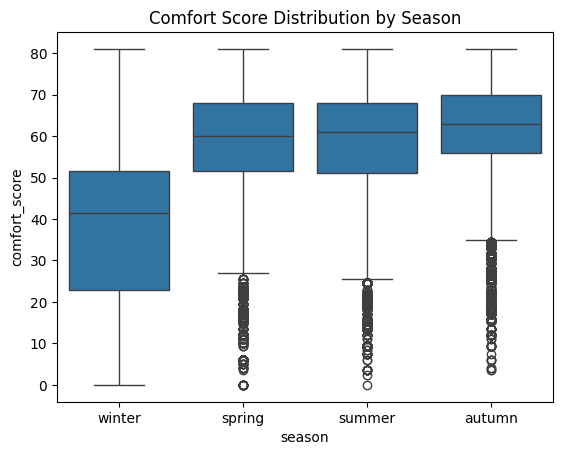

In [5]:
if not dataset.empty:
    df_season = dataset.copy()
    df_season["season"] = df_season["datetime"].dt.month.map({
        12: "winter", 1: "winter", 2: "winter",
        3: "spring", 4: "spring", 5: "spring",
        6: "summer", 7: "summer", 8: "summer",
        9: "autumn", 10: "autumn", 11: "autumn"
    })
    season_stats = df_season.groupby("season")[ ["temperature", "pm10", "comfort_score"] ].agg(["mean", "median", "std"])
    display(season_stats)

    sns.boxplot(data=df_season, x="season", y="comfort_score", order=["winter", "spring", "summer", "autumn"])
    plt.title("Comfort Score Distribution by Season")
    plt.show()


## 4. 지역별 패턴 분석
- 관측소 ID 기반 지역 구분(피처 빌더에서 생성)을 활용합니다.


temperature                                 pm10             \
               mean median        std   count       mean     median   
region                                                                
central   14.816251   15.8  10.569901  253275  24.808496  19.692308   
south     14.352334   15.7  10.733147   59449  28.283894  20.727273   
west      13.890952   15.2  11.339602   29776  25.678101  21.545455   

                           comfort_score                            
               std   count          mean median        std   count  
region                                                              
central  27.605860  253275     54.397370   57.0  16.300214  253275  
south    58.518676   59449     53.366819   56.5  16.851415   59449  
west     23.669966   29776     52.211580   56.0  17.559508   29776

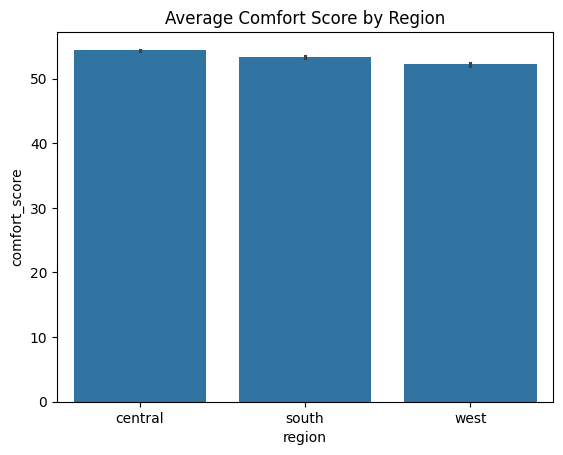

In [6]:
if not dataset.empty and "region" in dataset.columns:
    region_stats = dataset.groupby("region")[ ["temperature", "pm10", "comfort_score"] ].agg(["mean", "median", "std", "count"])
    display(region_stats.sort_values(("comfort_score", "mean"), ascending=False))

    sns.barplot(x="region", y="comfort_score", data=dataset)
    plt.title("Average Comfort Score by Region")
    plt.show()
else:
    logger.warning("region 컬럼이 없어 지역 분석을 건너뜁니다.")


## 5. 이상치 탐지
- IQR 기반 이상치를 찾고 샘플을 출력합니다.


In [7]:
if not dataset.empty:
    metrics = ["temperature", "pm10", "comfort_score"]
    anomalies = {}
    for metric in metrics:
        series = pd.to_numeric(dataset[metric], errors="coerce").dropna()
        q1, q3 = series.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = (dataset[metric] < lower) | (dataset[metric] > upper)
        anomalies[metric] = dataset.loc[mask, ["station_id", "datetime", metric]]
        display(anomalies[metric].head())
    anomalies


,station_id,datetime,temperature
4564,232,2024-01-09 16:00:00,-99.0
72219,232,2024-05-13 13:00:00,-99.0
117040,100,2024-08-04 11:00:00,-99.0
134767,140,2024-09-06 10:00:00,-99.0
187251,121,2024-12-12 13:00:00,-99.0


,station_id,datetime,pm10
195,146,2024-01-01 17:00:00,94.000000
218,146,2024-01-01 18:00:00,71.076923
244,169,2024-01-01 19:00:00,356.000000
1030,102,2024-01-03 06:00:00,64.923077
1053,102,2024-01-03 07:00:00,66.090909


,station_id,datetime,comfort_score
4,119,2024-01-01 09:00:00,12.0
7,135,2024-01-01 09:00:00,12.0
17,201,2024-01-01 09:00:00,6.0
20,273,2024-01-01 09:00:00,12.0
22,93,2024-01-01 09:00:00,12.0


## 6. 품질 리포트 및 액션 아이템
- 이상치, 결측, 품질 이슈를 종합해 텍스트로 정리합니다.


In [8]:
notes = []
if quality_issues:
    for level, messages in quality_issues.items():
        if messages:
            notes.append(f"{level.upper()}: {messages}")
if dataset.empty:
    notes.append("데이터셋이 비어 있습니다. S3에 데이터가 있는지 확인하세요.")

report_summary = "
".join(notes) if notes else "모든 데이터 품질 검사를 통과했습니다."
print(report_summary)


SyntaxError: unterminated string literal (detected at line 9) (2495994921.py, line 9)

## 7. 후속 분석 가이드
- 계절×지역 피벗 분석, 이상치 시점과 이벤트 비교, 모델링 변수 검토 등에 활용하세요.
